# How Data Quantity Drives Model Quality

  * John Mount
  * [Win Vector LLC](https://www.win-vector.com)
  * 2-April-2024

## Introduction

In this note we will examine how data quantity controls model quality. We will also look at several methods of estimating model quality.

It is important to note that by "more data" we mean additional independently generated training examples of a similar distribution and quality as previous training data. Duplicating existing data or adding lower quality data typically *does not* improve model quality. An important note is: this does *not* mean one removes duplicates in training data. If duplicates are occurring in the the real data generation process (and they are not due to a bug), then that is important beneficial modeling information that we do not want to lose.

Overall, the lesson we would like the reader to come away with is:

> Adding more training data makes estimated model performance better on held-out (or test) data and *worse* on training data.

These *are* apparently conflicting outcomes (test gets better, and train gets worse). This is not in fact a problem or contradiction, if we internalize the following two points.

  * Training performance tends to get worse as we add more training data, as we are then amortizing the over-fit bias of training over more training rows. The model isn't actually getting worse at what it does on training data, it is getting worse at lying to us about its performance.
  * Test or held out data (data not used in the training procedure) is the more reliable simulation of applying a model to future application data. This is because held out data shares a property of future application data: it wasn't used to train the model. Test, hold-out, or cross-evaluation tend to be more reliable than in-sample (or on training) model evaluation.

The disparity between in-sample (or training) and out-of-sample (hold out, test, or future application) is called "excess generalization error" or "over-fit." This is "basic stuff", however few people have internalized "more data makes training performance *worse*" to a reflex level. Also, I feel too few people remember in-sample adjusted loss estimate *perfect* model performance, and *not* the expected performance of the fit model (so they are removing a bias, but not the one many people remember).

## A Linear Model Example

Let's set up a synthetic data set.  The advantages of synthetic data include:

  * It is easy to acquire.
  * We can design it so we know the right answer.

In this lesson we are using test data to represent future unseen data. So we will not use the "ideal" test set as part of the training process. It is our gold standard evaluation. In real projects we don't always have this luxury.


### Setting up the example data


We start by initializing our Python environment and setting some parameters of the simulation.

In [1]:
# import our modules and packages
import numpy as np
import pandas as pd
from overfit_fns import (
    run_training_size_modeling_experiments,
    plot_error_curves,
)

In [2]:
# initialize pseudo random generator
rng = np.random.default_rng(2018)

In [3]:
# pick example parameters
var_strength = 0.3
n_parameters = 20

The following `mk_data()` function generates an example regression (numeric prediction) problem as follows.

  * We start with the dependent or outcome variable `y` as a standard-normal (mean 0, variance 1) random variable representing unexplainable variation or variance (not predictable, as it is not yet generated jointly with any modeling variables). Over-fit is when a modeling techniques faultily tries to explain unexplainable variance using chance *apparent* correlations in the training data as if they are true repeatable associations.
  * We then build up explanatory variables. These add some explainable variation to the outcome variable.

In [4]:
# our synthetic data generation process
def mk_data(
        m_row: int,
        n_variables: int,
    ):
    y = rng.normal(0, 1, m_row)
    df = dict()
    for i in range(n_variables):
        var_name = "var_" + str(i).zfill(4)
        df[var_name] = rng.normal(0, 1, m_row)
        y = y + var_strength * df[var_name]
    df['y'] = y
    return pd.DataFrame(df)


In [5]:
# our large test data set we use to
# estimate true model quality
# in practice we often can not estimate
# true model quality so simply
# (must simulate using some training data 
# as hold out or cross validation methods.)
d_large_ideal_test = mk_data(100000, n_parameters)


In [6]:

# expected root mean square error
# of the model that always predicts zero
# a "null" or straw man to measure our performance
# relative to.
# as our data process outcome is mean zero, this
# is a non-silly basic estimate.
rmse_null = np.sqrt(1.0 + var_strength**2 * n_parameters)

# expected root mean square error of a perfect
# model. this is the magnitude of the unexplainable
# variance in the data generation process.
rmse_perfect = 1.0

### Running the experiment

We evaluate the model quality both on its own training data (a bad practice) and on held out test test (a good practice). We do this to show the different qualities of these two practices.


This procedure is pretty good, and will let us see everything we need. However, this estimation process is unstable and noisy for small training set sizes- *independent of the test set size*.

In [7]:
# run all of the simulations or experiments
plot_frame = run_training_size_modeling_experiments(
    d_large_ideal_test=d_large_ideal_test,
    example_factory=mk_data,
    rng=rng,
    rmse_null=rmse_null,
    rmse_perfect=rmse_perfect,
    alphas = [1e-6, 1e-2, 100, 10000],
)

In [8]:
# show an excerpt
plot_frame

,training rows,n variables,n parameters,alpha,measurement,value,L2 regularization,rmse_null,rmse_perfect
0,1,20,20,0.000001,RMSE train,1.228188e-07,1e-06,1.67332,1.0
1,1,20,20,0.000001,RMSE train adjusted,inf,1e-06,1.67332,1.0
2,1,20,20,0.000001,RMSE train cross,2.241587e+00,1e-06,1.67332,1.0
3,1,20,20,0.000001,RMSE ideal test,1.578744e+00,1e-06,1.67332,1.0
0,2,20,20,0.000001,RMSE train,5.217586e-08,1e-06,1.67332,1.0
...,...,...,...,...,...,...,...,...,...
3,399,20,20,10000.000000,RMSE ideal test,1.629946e+00,10000.0,1.67332,1.0
0,400,20,20,10000.000000,RMSE train,1.635141e+00,10000.0,1.67332,1.0
1,400,20,20,10000.000000,RMSE train adjusted,1.677620e+00,10000.0,1.67332,1.0
2,400,20,20,10000.000000,RMSE train cross,1.642204e+00,10000.0,1.67332,1.0


#### Plotting performance on training (a bad practice)

We can now plot the evaluated model quality as follows. For this note we wil only plot the model quality when we "sufficient data", which we are defining as having at least twice as many examples as model parameters. This is "ad-hoc" rule that can not always be correct, and it is smaller than the typical [events per parameter (EVP) "one in ten rule"](https://en.wikipedia.org/wiki/One_in_ten_rule) (please see Harrell et. al. and  Riley et. al.).

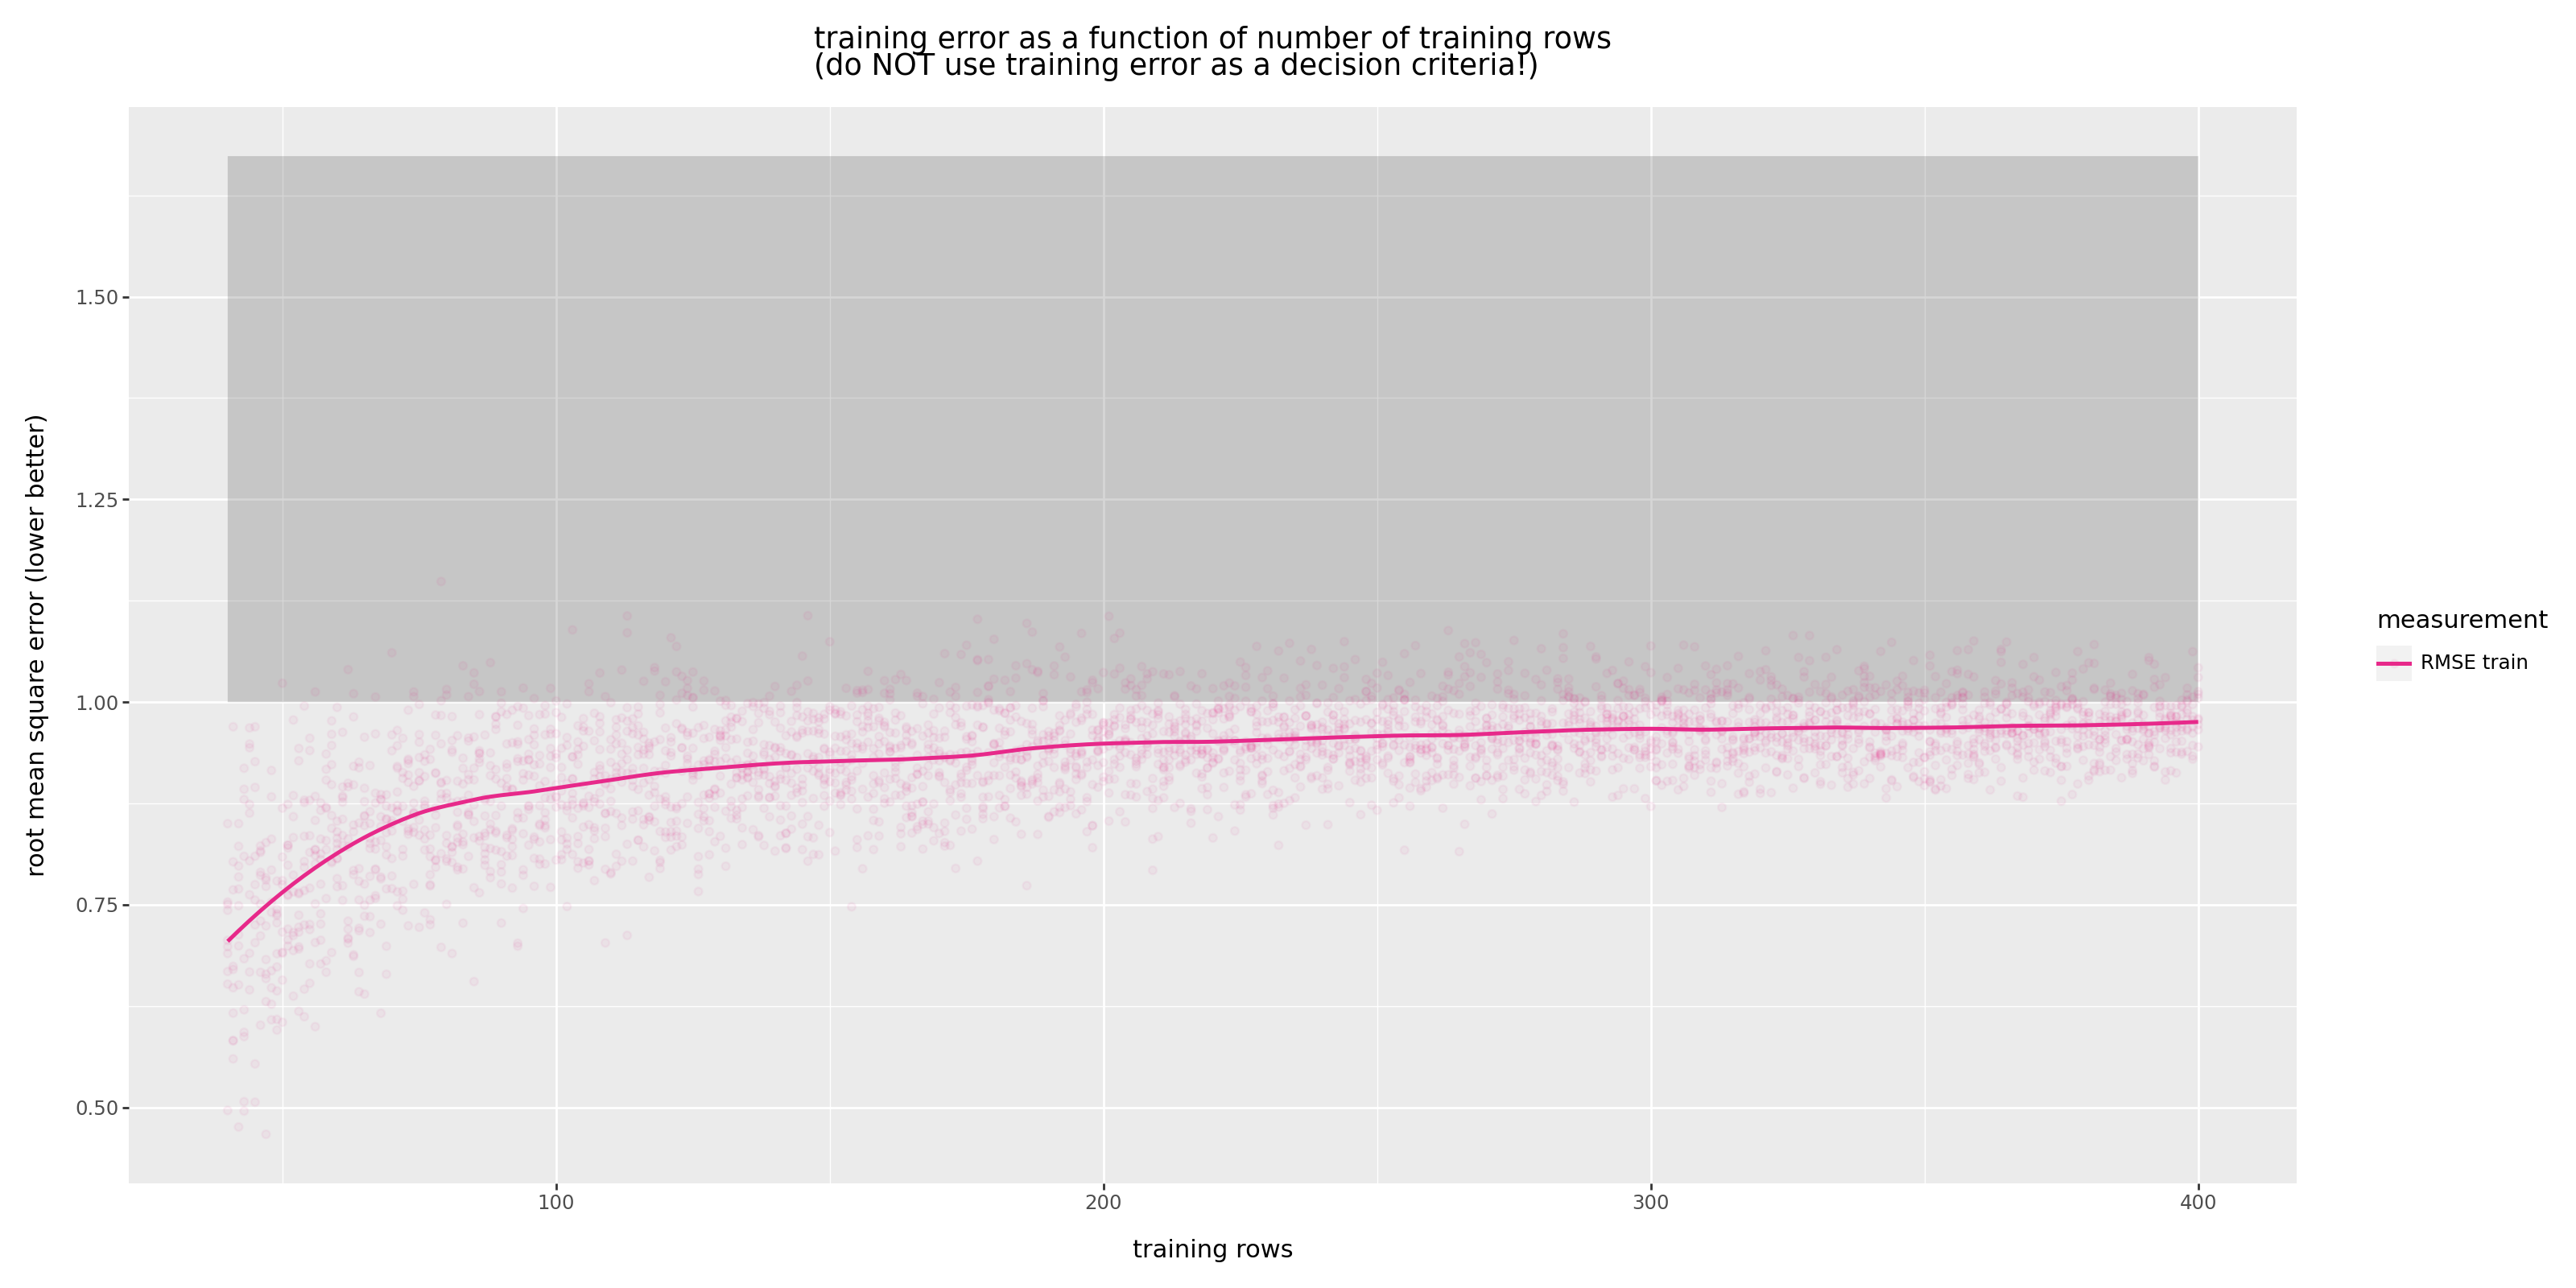

In [9]:
alpha_min = np.min(plot_frame['alpha'])
plot_error_curves(
    plot_frame.loc[
        (plot_frame['alpha'] == alpha_min)
        & (plot_frame['measurement'] == 'RMSE train')
        & (plot_frame['training rows'] >= 2 * n_parameters)
        ,:],
    draw_lines=False,
    draw_smooth=True,
    title="training error as a function of number of training rows\n(do NOT use training error as a decision criteria!)",
    )

The above graph summarizes the outcomes of a great number of experiments. On the x axis we have the number of data rows used as training. On the y axis we have the resulting root mean square error of the model evaluated on its own training data (a bad practice). Root mean square error ([RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation)) is a [loss](https://en.wikipedia.org/wiki/Loss_function) or criticism, so smaller is better. Each dot is an experiment we ran. The curves are smoothed averages to show the result trends. We are only evaluating the procedure when we have many more training examples than model parameters (a good standard practice).

Root mean square error is an example of a "loss." As such, lower is better.

The grey region portrays a range of model qualities. The lower boundary is the unexplainable variation from the data generation process, which is also the expected measured performance of the best possible model using these variables. The high boundary is the expected measured performance of a "null model" (in this case one that always predicts zero or the expected unconditional mean). By "null model" we just mean a model that doesn't really know much.

The first thing to notice is: the loss measured on training is generally getting *worse* as use larger training sets! *If* we were to treat the number of training rows as a hyper-parameter, the training performance graph would lead us to pick small sizes (such as 1 row!) as the optimal training set size. This is, of course, ridiculous and bad advice. To summarize: unadjusted choices made on losses computed over training data should not be relied on. 

Also, we do *not* recommend treating training set size as a detailed hyper-parameter. Reasons to avoid this include:

  * We should already know the right answer (modulo diminishing returns): more training data.
  * Treating everything as a detailed hyper-parameters (that is one where the exact value matters) just invites additional negative opportunities for over-fit through [multiple comparison bias](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). Save your out of sample or cross-method opportunities for important hyper-parameters that you do not know the optimal value of.

#### Plotting performance on test (a good practice)

Now we create the same graph on data not used during model construction. This data is statistically identical to the training data prior to model construction. The only difference is: this data wasn't used to build the model, so doesn't pick up the "measured on training" bias issue.

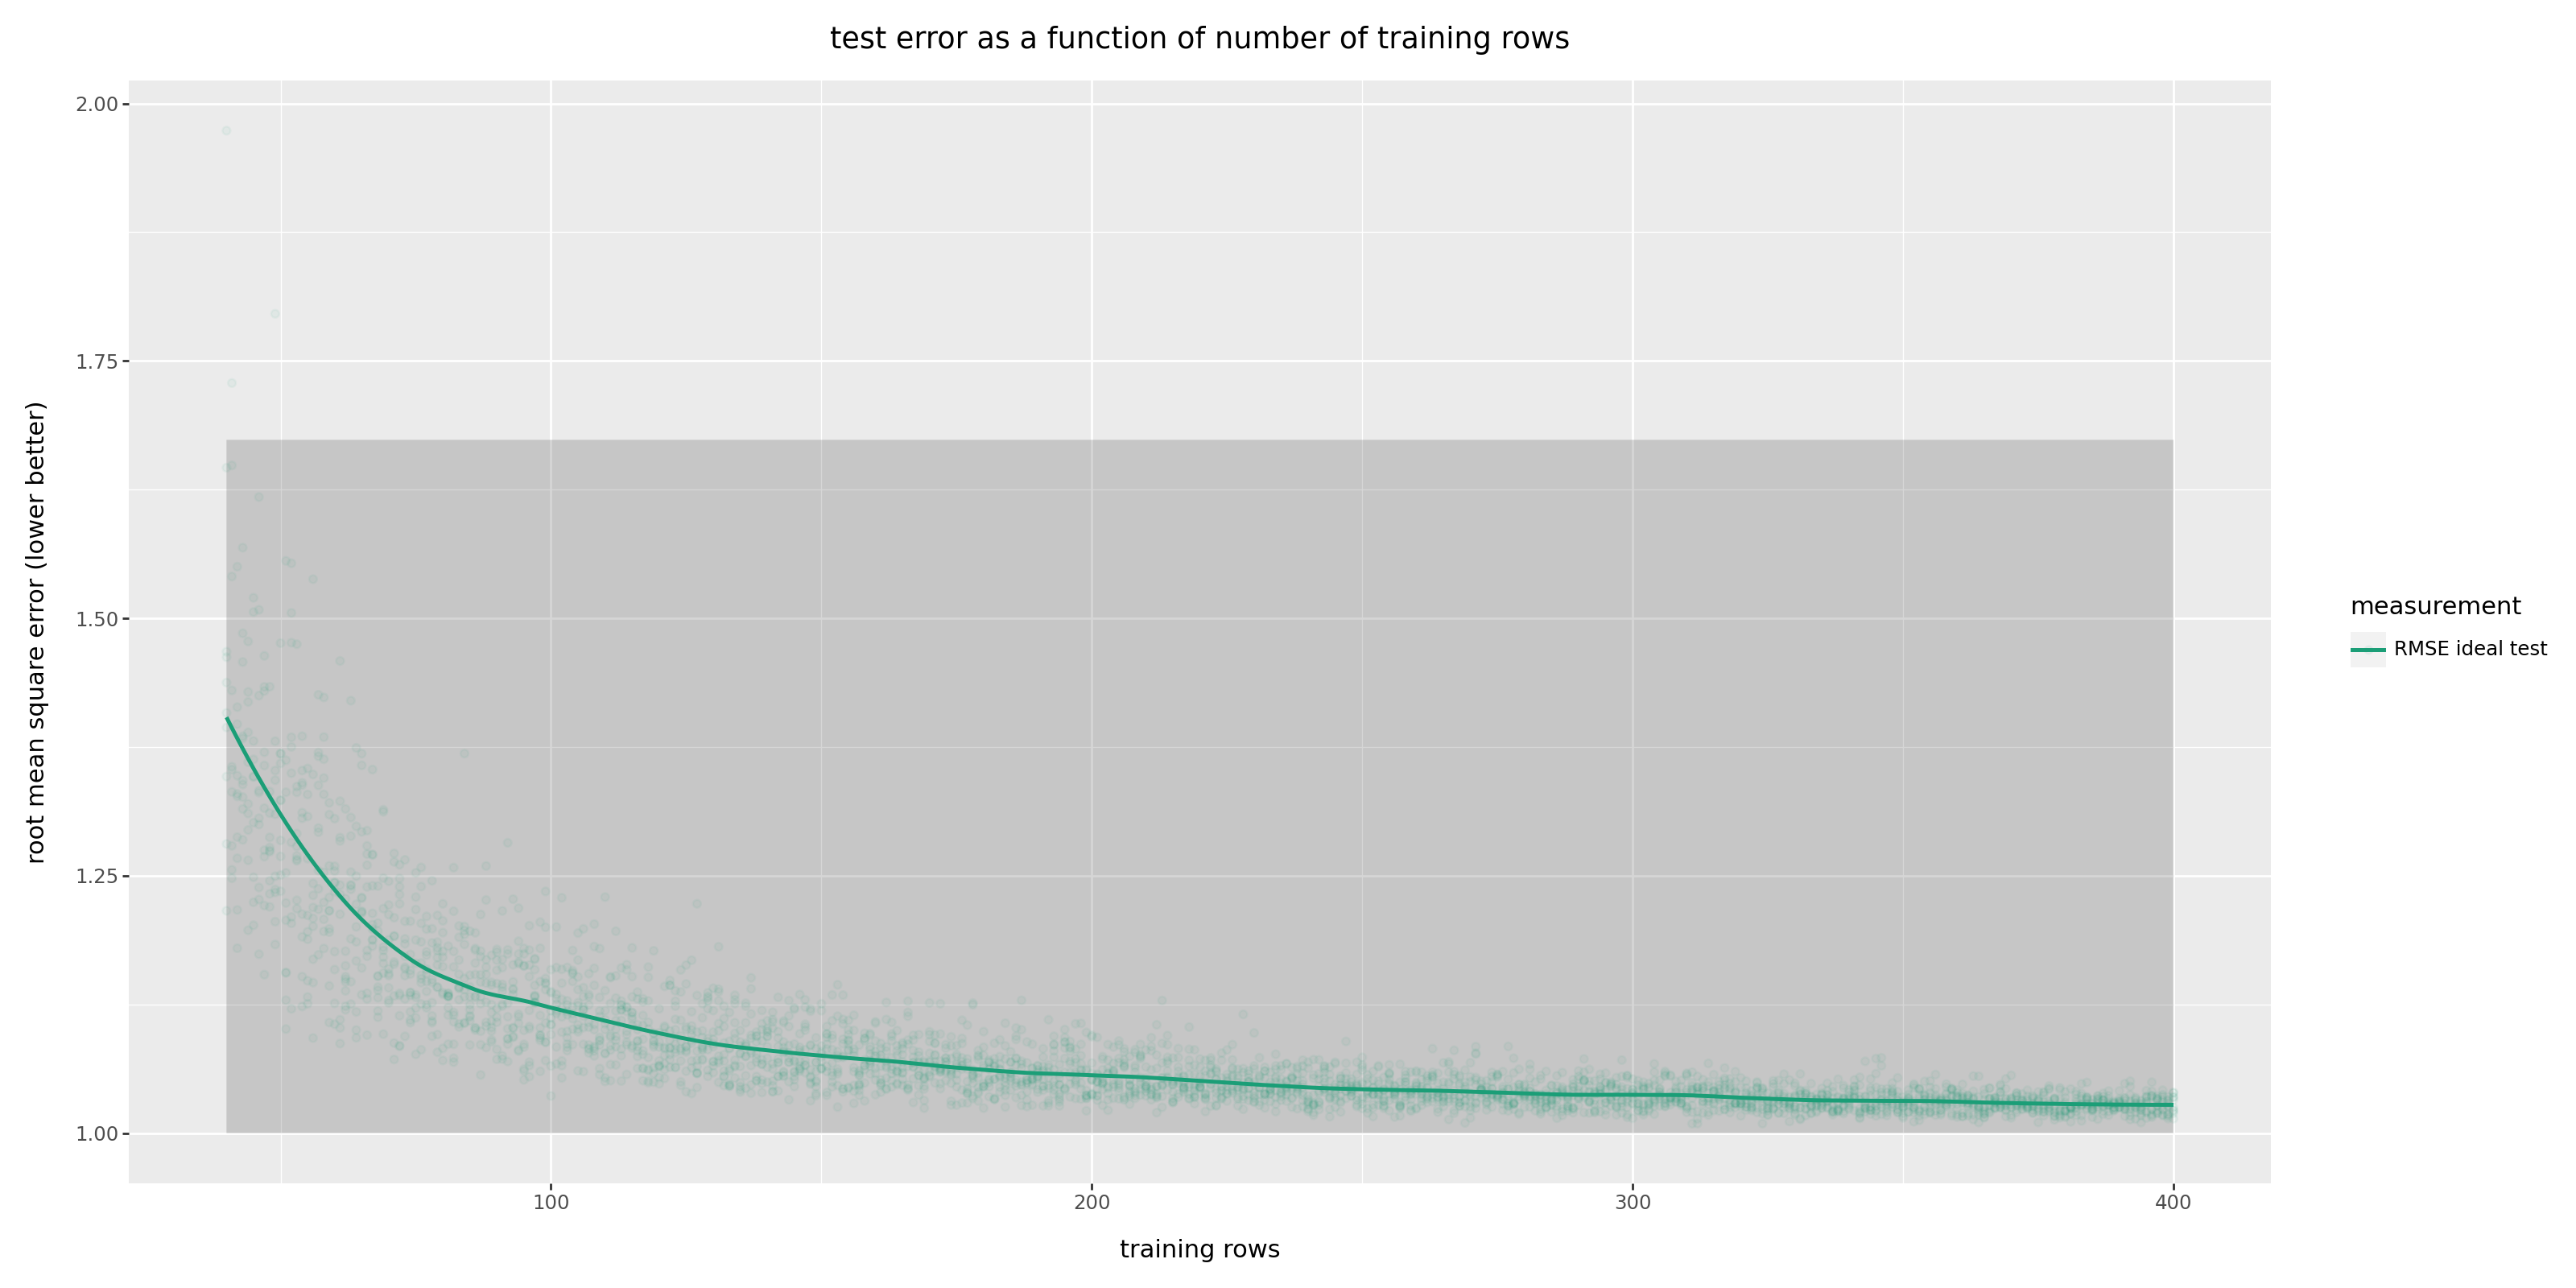

In [10]:
plot_error_curves(
    plot_frame.loc[
        (plot_frame['alpha'] == alpha_min)
        & (plot_frame['measurement'] == 'RMSE ideal test')
        & (plot_frame['training rows'] >= 2 * n_parameters)
        ,:],
    draw_lines=False,
    draw_smooth=True,
    title="test error as a function of number of training rows",
    )

Now we have the relation people remember: more data decreases *expected* out of sample (test or application) loss. Any wiggles in the graph are just noise due to sampling effects, but the overall graph is monotone decreasing.

The graph says: more data is better, but with a diminishing return. One can even say "m rows of data tend to be worth sqrt(m) in value."

## The Overall Picture

We can combine the above two graphs to get a better sense of scale and the opposite test/train behaviors.

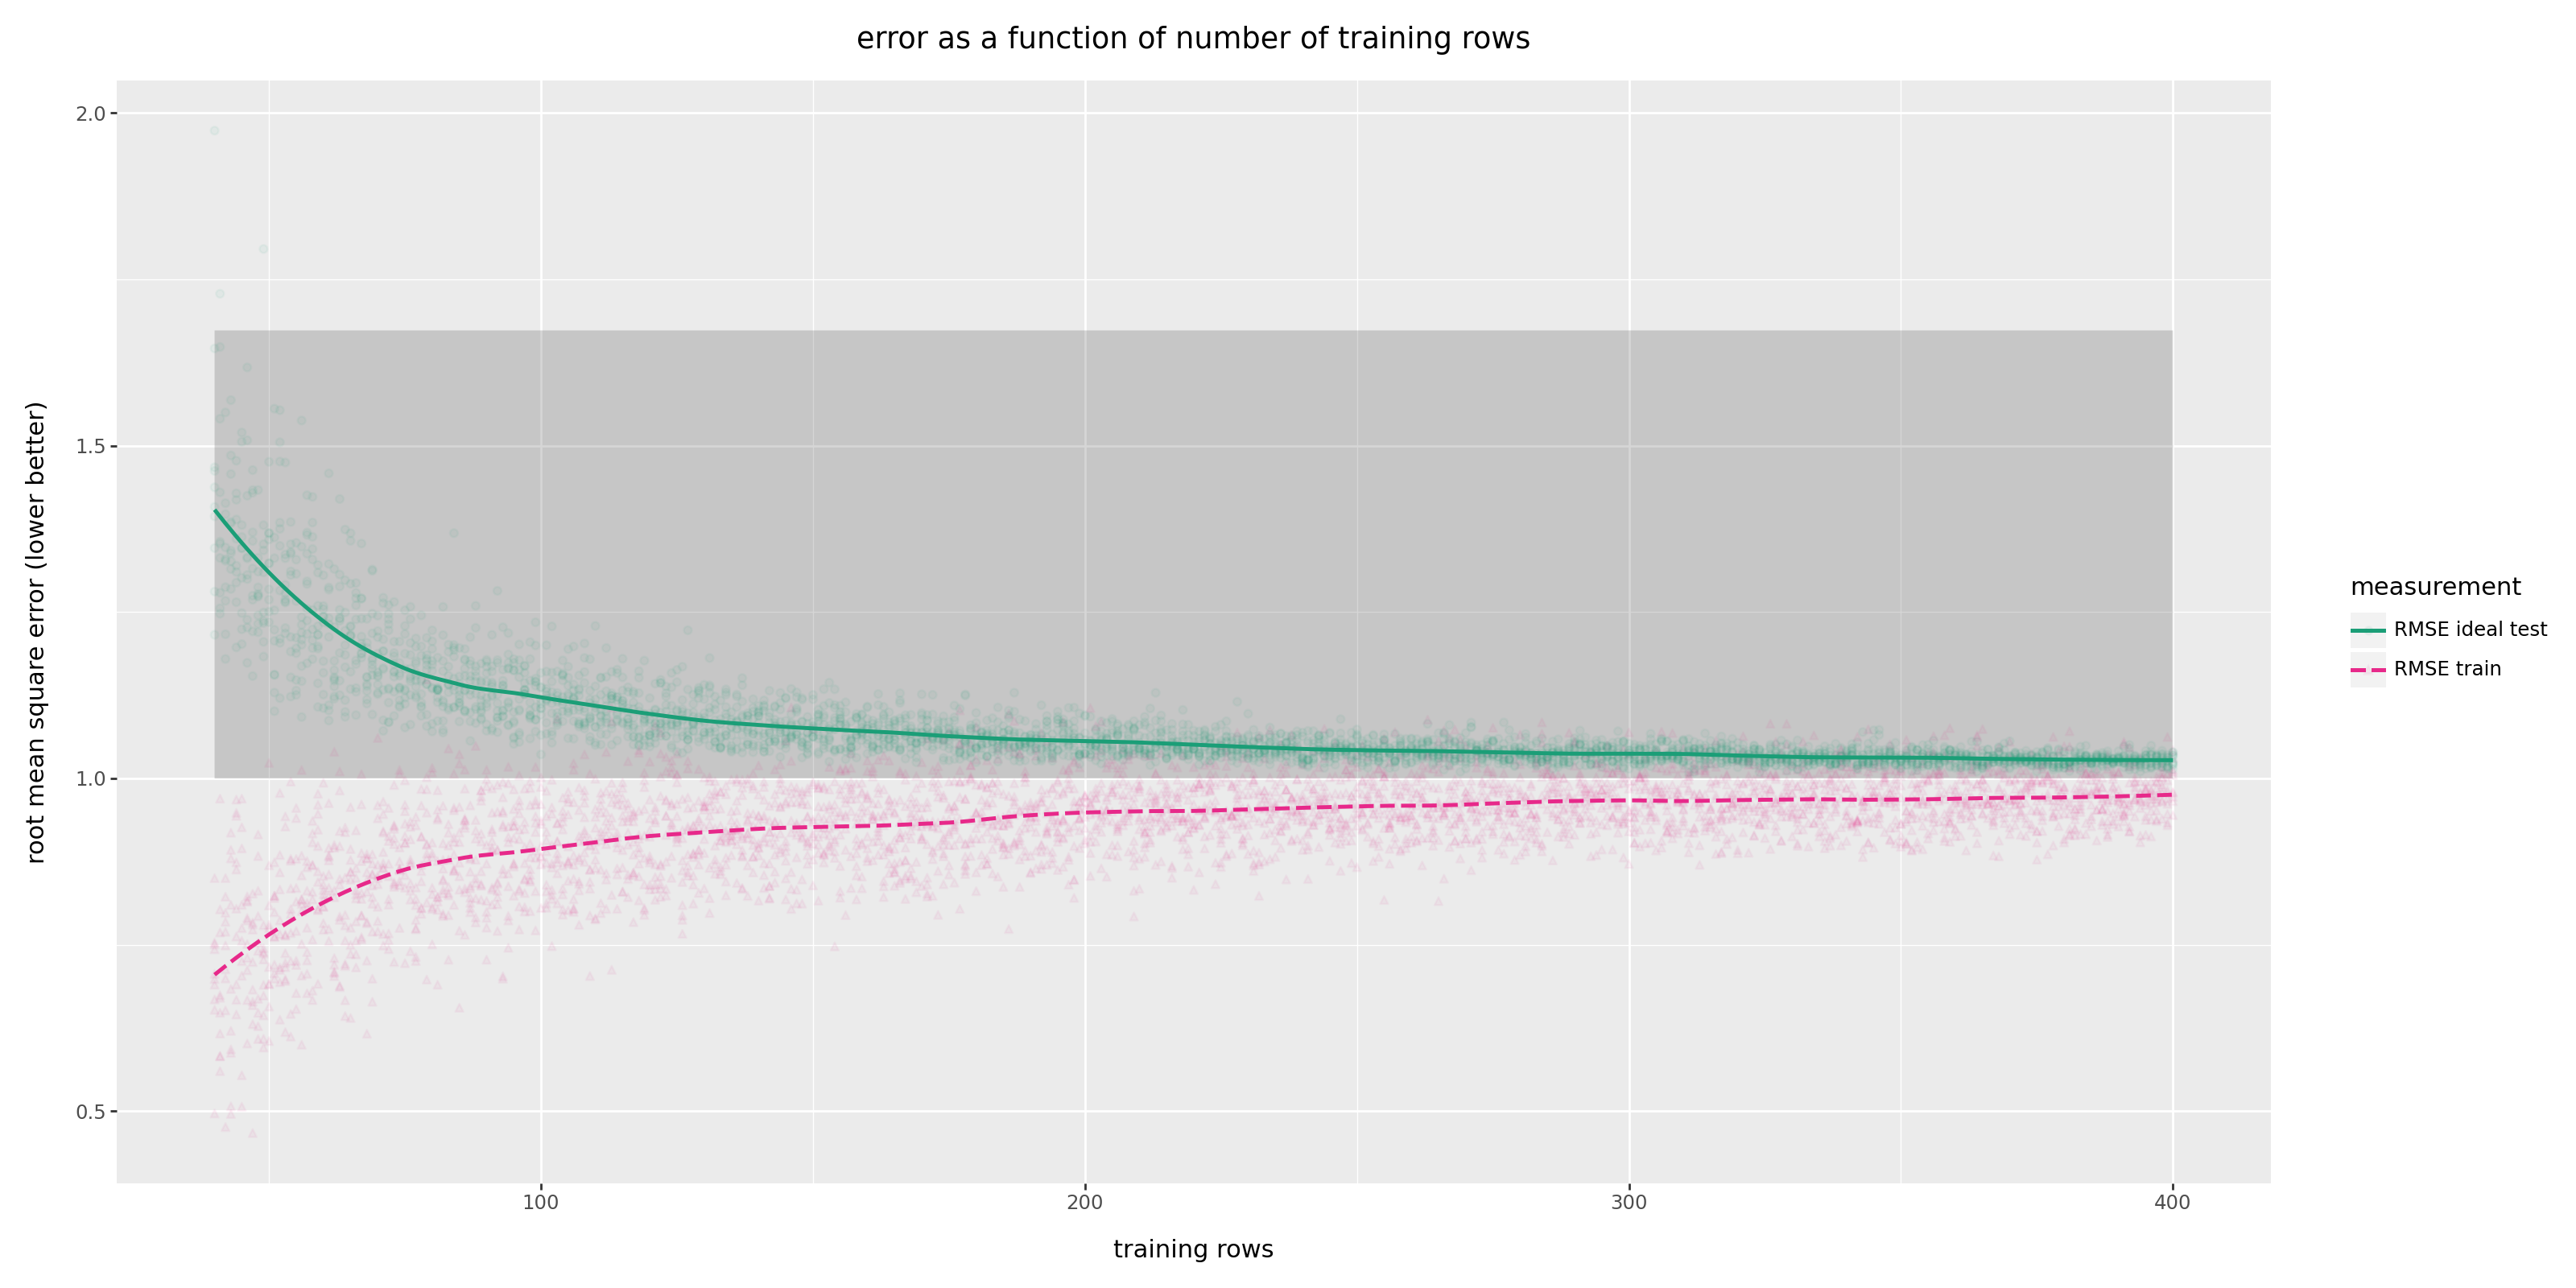

In [11]:
plot_error_curves(
    plot_frame.loc[
        (plot_frame['alpha'] == alpha_min)
        & (np.isin(plot_frame['measurement'], ['RMSE ideal test', 'RMSE train']))
        & (plot_frame['training rows'] >= 2 * n_parameters)
        ,:],
    draw_lines=False,
    draw_smooth=True,
    title="error as a function of number of training rows",
    )

Notice the test and train errors appear to be approaching the shared asymptote of the perfect model's behavior. In practice we don't usually know what perfect model behavior would be, but we can inspect for such asymptote-like behavior.

Please remember this shape as your "how does training set size affect model quality?" rule.


### Additional estimates

There are two common additional estimates of model quality:

  * Measured training error "[adjusted for degrees of freedom](https://win-vector.com/2023/03/16/bounding-excess-generalization-error-for-linear-regression-models/)". We will call this "RMSE train adjusted", and is the same sort of Bessel correction that gives the common "adjusted R-squared."
  * [Cross validated error](https://en.wikipedia.org/wiki/Cross-validation_(statistics)). We will call this "RMSE train cross".

Let's add these measurements to the graph.

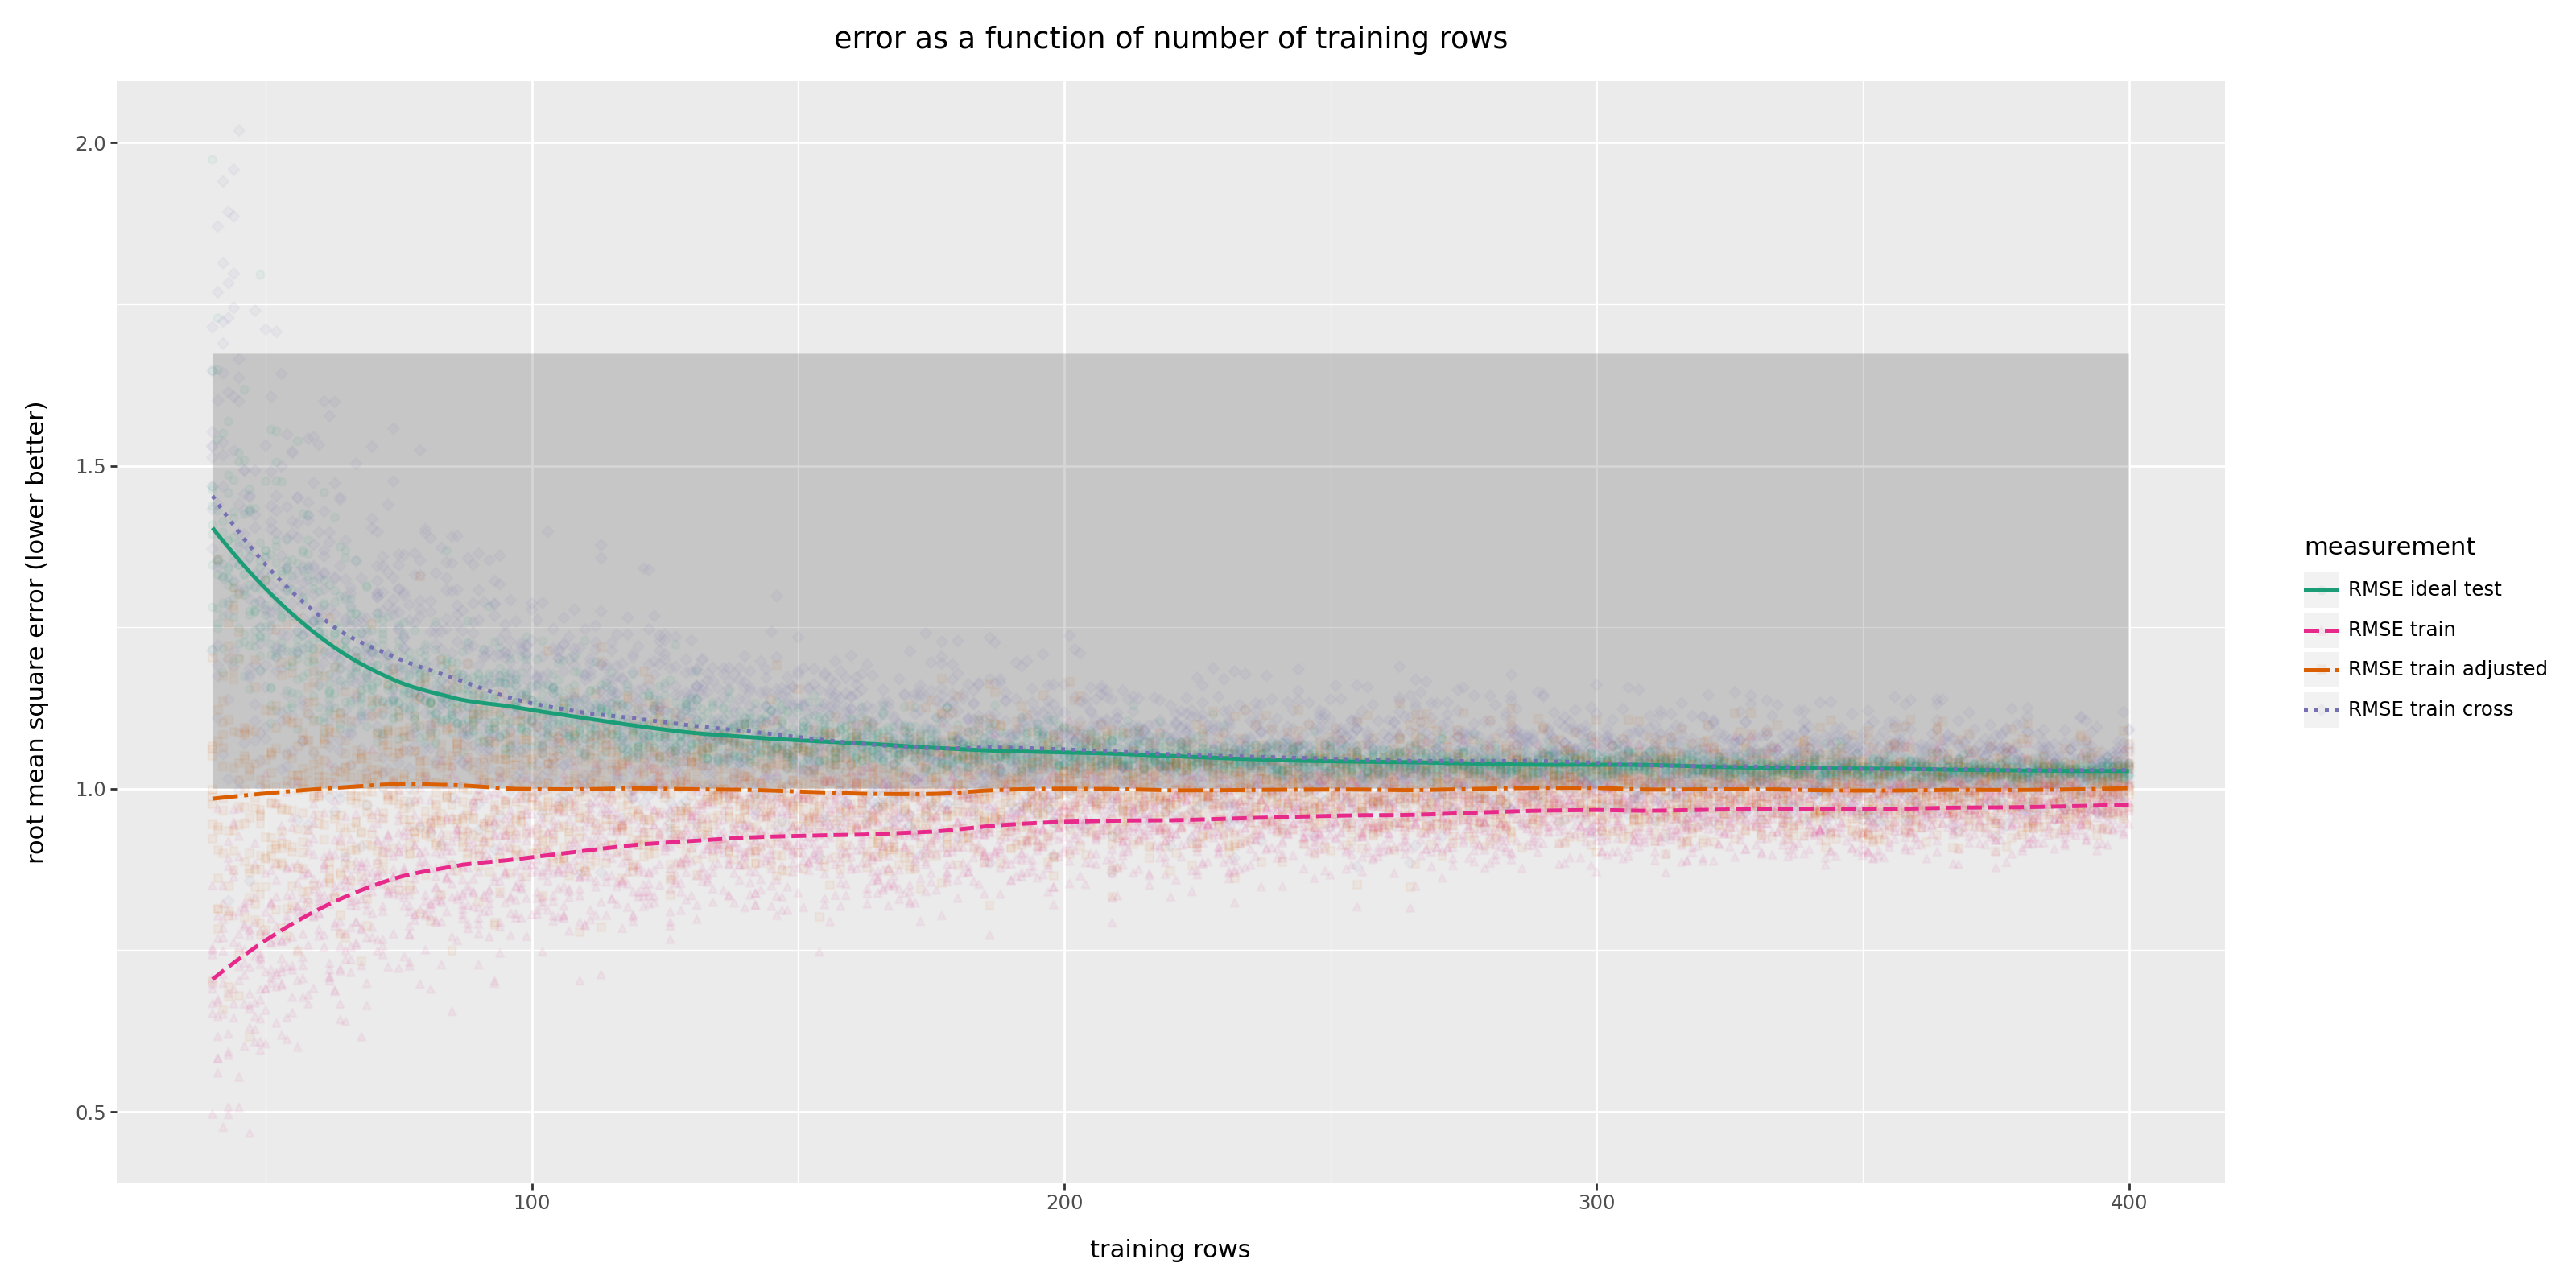

In [12]:
plot_error_curves(
    plot_frame.loc[
        (plot_frame['alpha'] == alpha_min)
        & (plot_frame['training rows'] >= 2 * n_parameters)
        ,:],
    draw_lines=False,
    draw_smooth=True,
    title="error as a function of number of training rows",
    )

The three visible trend curves (there are 4 curves, but two of them are stacked on top of each other) give us 3 different families of measurement: 

  * performance on training data (not interesting, as we don't need model if we have the marked outcomes)
  * ideal performance (not always achievable with the amount of training data we have)
  * expected future performance of the model we are actually able to fit.

Notice the cross estimated error, which is calculated using held out portions of the training data, almost perfectly tracks the ideal test error. This is why cross validation and other hold out procedures are used: they tend to be good at estimating performance on future unseen application data.

The curve "RMSE train adjusted" estimates the expected quality of a perfect model, not the quality of the model in hand (which is the "RMSE ideal test" curve)! To repeat: classic [Bessel degrees of freedom adjustment](https://en.wikipedia.org/wiki/Bessel%27s_correction) is not designed to estimate future model performance of the fit model. One has to consider the Bessel correction or adjustment as a tool to factor out model complexity when comparing different modeling choices (such as how many variables to use). 


## Discussion


Let's look at a single example situation.

In [13]:
(
    plot_frame
        .loc[
            (plot_frame['alpha'] == alpha_min)
            & (plot_frame['training rows'] == 100)
            , ["measurement", "value"]]
        .groupby('measurement')
        .mean()
)

,value
measurement,
RMSE ideal test,1.107069
RMSE train,0.915657
RMSE train adjusted,1.023736
RMSE train cross,1.158323



From the graph we see for `m = 100` example rows or instances, and `n = 20` model parameters or variables (and a small amount regularization):

  * "RMSE ideal test" is 1.11 units. This is the expected performance of a model fit on 100 examples on new data.
  * "RMSE train cross" is 1.16 units. This is the estimated performance of the fit model on new data, where the estimate is produced using cross validation methods on the training data. This statistic can be estimated other ways, such as [the PRESS statistic](https://win-vector.com/2014/09/25/estimating-generalization-error-with-the-press-statistic/).
  * "RMSE train" is 0.92 units. This the model's performance directly on its own training data. This is a level of performance we will not see on future application data.
  * "RMSE train adjusted" is 1.02 units. This is the [degrees of freedom adjustment](https://win-vector.com/2023/03/16/bounding-excess-generalization-error-for-linear-regression-models/) estimate of unexplainable variance, or behavior of a best possible model using these variables. Notice this is smaller than what the fit model actually does on future data. This is *again* a level of performance we will not see on future application data.

The first two estimates are promises you can keep, the next two estimates are *both* commitments that you can not meet. It is important to realize there are *three* fundamentally different (but related) measurements above: behavior of a model on its own training data, behavior of the same model on new data, and ideal unexplainable variance. Using the wrong one of these can drive confusion.

For large `m` we expect:

  * `rmse_train_cross ~ rmse_ideal_test`. These are trying to estimate the same thing: future performance of the model we have fit.
  * `rmse_train_adjusted = sqrt(m/(m-n)) rmse_train`. This is a [Bessel style correction](https://en.wikipedia.org/wiki/Bessel%27s_correction). It is is an estimate of the unexplainable variance in the data generation process. This is also the expected performance of a *perfect* model using these variables.
  * `(rmse_train + rmse_train_adjusted)/2 ~ rmse_train_cross`. This should hold as the mis-estimate of model parameters that gives over-fit on the training data then contributes to additional errors on new data. A little algebra then gives us `rmse_train_cross ~ (2 sqrt(m/(m-n)) - 1) rmse_train`. So we can try to estimate out of model performance by adjustment, but it is not exactly the Bessel correction. For our example we get the fit model should have an RMSE of about `(2 * sqrt(100/(100 - 20)) - 1) * 0.915657 = 1.13` which is actually near the `RMSE ideal test` and `RMSE train cross` estimates.

If you have been reporting adjusted R-squared as a prediction of future model performance, you really should change to out of sample test, hold-out, or cross procedures.

## Conclusions

  * More data *is* better.
  * Directly evaluating model quality on training data is not relevant, unless special care and/or adjustments are taken. Direct evaluation on training data doesn't simulate how we are going to actually use the model in the future: on new unseen data.
  * Bessel corrections or adjustments (such as to RMSE or R-squared) estimate perfect model performance, *not* the future performance of the fit model.
  * Adjusted R-squared is a tool to factor out model complexity for comparison, and to help reject bad modeling proposals. These methods should not be considered as a model acceptance criteria.
  * Holdout and cross-methods can give reliable training data based estimates of future model performance.

In our next lesson we will work with smaller training set sizes, and use a method called [regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics)) to speed up inference and mitigate low-data issues.


## Appendices

### References

  * Freedman, David A. "A Note on Screening Regression Equations", The American Statistician, May 1984, Vol. 37. No. 2.
  * Halevy, A., Norvig, P. Pereira, F. "The Unreasonable Effectiveness of Data", IEEE Intelligent Systems ( Volume: 24, Issue: 2, March-April 2009), DOI: 10.1109/MIS.2009.36.
  * Harrell, F. E. Jr.; Lee, K. L.; Mark, D. B. (1996). "Multivariable prognostic models: issues in developing models, evaluating assumptions and adequacy, and measuring and reducing errors" Stat Med. 15 (4): 361–87.
  * Mount, J. "Bounding Excess Generalization Error for Linear Regression Models", Win Vector blog [https://win-vector.com/2023/03/16/bounding-excess-generalization-error-for-linear-regression-models/](https://win-vector.com/2023/03/16/bounding-excess-generalization-error-for-linear-regression-models/).
  * Peduzzi, Peter; Concato, John; Kemper, Elizabeth; Holford, Theodore R.; Feinstein, Alvan R. (1996). "A simulation study of the number of events per variable in logistic regression analysis". Journal of Clinical Epidemiology. 49 (12): 1373–1379. doi:10.1016/s0895-4356(96)00236-3. PMID 8970487.
  * Riley RD, Ensor J, Snell KIE, Harrell FE Jr, Martin GP, Reitsma JB, Moons KGM, Collins G, van Smeden M. Calculating the sample size required for developing a clinical prediction model. BMJ. 2020 Mar 18;368:m441. doi: 10.1136/bmj.m441. PMID: 32188600.
  * Wikipedia, "One in ten Rule" [https://en.wikipedia.org/wiki/One_in_ten_rule](https://en.wikipedia.org/wiki/One_in_ten_rule).
  * Zumel, N. "Estimating Generalization Error with the PRESS statistic", Win Vector blog [https://win-vector.com/2014/09/25/estimating-generalization-error-with-the-press-statistic/](https://win-vector.com/2014/09/25/estimating-generalization-error-with-the-press-statistic/).
  * Zumel, N., Mount, J. *Practical Data Science with R*, 2nd Edition [Manning](https://www.manning.com/books/practical-data-science-with-r-second-edition), 2020. [Amazon](https://www.amazon.com/Practical-Data-Science-Nina-Zumel-dp-1617295876/dp/1617295876/).

### Glossary Terms

  * "Bessel's correction" [https://en.wikipedia.org/wiki/Bessel%27s_correction](https://en.wikipedia.org/wiki/Bessel%27s_correction).
  * "Coefficient of determination" [https://en.wikipedia.org/wiki/Coefficient_of_determination](https://en.wikipedia.org/wiki/Coefficient_of_determination).
  * "Cross-validation (statistics)" [https://en.wikipedia.org/wiki/Cross-validation_(statistics)](https://en.wikipedia.org/wiki/Cross-validation_(statistics)).
  * "Double descent" [https://en.wikipedia.org/wiki/Double_descent](https://en.wikipedia.org/wiki/Double_descent).
  * "Hyperparameter (machine learning)" [https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)).
  * "Generalization Error" [https://en.wikipedia.org/wiki/Generalization_error](https://en.wikipedia.org/wiki/Generalization_error).
  * "Linear Regression" [https://en.wikipedia.org/wiki/Linear_regression](https://en.wikipedia.org/wiki/Linear_regression).
  * "Multiple comparisions problem" [https://en.wikipedia.org/wiki/Multiple_comparisons_problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem).
  * "One in ten Rule" [https://en.wikipedia.org/wiki/One_in_ten_rule](https://en.wikipedia.org/wiki/One_in_ten_rule).
  * "Regularization (mathematics)" [https://en.wikipedia.org/wiki/Regularization_(mathematics)](https://en.wikipedia.org/wiki/Regularization_(mathematics)).


All code and data for this article can be found [here](https://github.com/WinVector/Examples/tree/main/TrainingSetSize).

Copyright &copy; 2018-2024 Win-Vector LLC.  All rights reserved. [http://www.win-vector.com](http://www.win-vector.com)


